## C. MONTH TRAINING

This notebook is used to find the correlation between customers monthly behavior and current defaulting rates. It follows the similar idea as in previous training and bureau training. Here we groupby month to create the training set. The target is currently target broadcasted: all month records for the same user share the same target. Use LightGBM classifier to predict the probability of a certain month record belonging to a user default currently. The predictions (probability between 0 and 1) are grouped by current ID and stats such as mean/sum are computed to create the features we will merge to the main training table.

Note because monthly records of a same loan are likely to share same values for some features -- such as the same amount of monthly payment. This may introduce a leak to our model as the model may start to find out records with a certain monthly payment all have a certain target. To avoid the leak, we will place records of same customer in the same fold while doing cross validation, so that early-stopping can be triggered when the model starts to exploit information that cannot be generalized to test set.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from lightgbm import LGBMClassifier, LGBMRegressor
import gc

import os
print(os.listdir('C:/Users/monis/Desktop/Home credit risk'))
    
gc.enable()

['.ipynb_checkpoints', 'Automated Hyper parameter tuning.ipynb', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bayes_test.csv', 'H20AutoML.ipynb', 'HomeCreditRiskKaggle.ipynb', 'Kaggle competition.docx', 'LightGBM with Simple Features.ipynb', 'log_reg_baseline.csv', 'random_forest_baseline.csv', 'random_forest_baseline_domain.csv', 'sample_submission.csv']


Aggragate pos cash.

In [3]:
pos = pd.read_csv('POS_CASH_balance.csv')
num_aggragations = {
    'SK_ID_PREV': ['count'],
    'CNT_INSTALMENT': ['mean','max','sum'],
    'CNT_INSTALMENT_FUTURE': ['mean','max','sum'],
    'SK_DPD': ['mean','max','sum'], 
    'SK_DPD_DEF': ['mean','max','sum'], 
}
pos = pos.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggragations)
pos.columns = pd.Index(['pos_' + e[0] + "_" + e[1].upper() for e in pos.columns.tolist()])
pos.head()

pos_SK_ID_PREV_COUNT  pos_CNT_INSTALMENT_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                                  
100001     -96                                1                      4.0   
           -95                                1                      4.0   
           -94                                1                      4.0   
           -93                                1                      4.0   
           -57                                1                      4.0   

                           pos_CNT_INSTALMENT_MAX  pos_CNT_INSTALMENT_SUM  \
SK_ID_CURR MONTHS_BALANCE                                                   
100001     -96                                4.0                     4.0   
           -95                                4.0                     4.0   
           -94                                4.0                     4.0   
           -93                                4.0                     4.0   
           -57                                4.0                     4.0   

                           pos_CNT_INSTALMENT_FUTURE_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                   
100001     -96                                        2.0   
           -95                                        1.0   
           -94                                        0.0   
           -93                                        0.0   
           -57                                        4.0   

                           pos_CNT_INSTALMENT_FUTURE_MAX  \
SK_ID_CURR MONTHS_BALANCE                                  
100001     -96                                       2.0   
           -95                                       1.0   
           -94                                       0.0   
           -93                                       0.0   
           -57                                       4.0   

                           pos_CNT_INSTALMENT_FUTURE_SUM  pos_SK_DPD_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                                   
100001     -96                                       2.0              0.0   
           -95                                       1.0              7.0   
           -94                                       0.0              0.0   
           -93                                       0.0              0.0   
           -57                                       4.0              0.0   

                           pos_SK_DPD_MAX  pos_SK_DPD_SUM  \
SK_ID_CURR MONTHS_BALANCE                                   
100001     -96                          0               0   
           -95                          7               7   
           -94                          0               0   
           -93                          0               0   
           -57                          0               0   

                           pos_SK_DPD_DEF_MEAN  pos_SK_DPD_DEF_MAX  \
SK_ID_CURR MONTHS_BALANCE                                            
100001     -96                             0.0                   0   
           -95                             7.0                   7   
           -94                             0.0                   0   
           -93                             0.0                   0   
           -57                             0.0                   0   

                           pos_SK_DPD_DEF_SUM  
SK_ID_CURR MONTHS_BALANCE                      
100001     -96                              0  
           -95                              7  
           -94                              0  
           -93                              0  
           -57                              0

Aggragate installment payments.

In [4]:
inst = pd.read_csv('installments_payments.csv')
inst_NUM_INSTALMENT_VERSION = inst.groupby(['SK_ID_PREV'])['NUM_INSTALMENT_VERSION'].nunique()

#merge payments of same month
#maybe helpful for: inst.loc[(inst.SK_ID_PREV==1000005) & (inst.SK_ID_CURR==176456) & (inst.NUM_INSTALMENT_NUMBER==9)]
inst['DAYS_ENTRY_PAYMENT_weighted'] = inst['DAYS_ENTRY_PAYMENT'] * inst['AMT_PAYMENT']
inst['MONTHS_BALANCE'] = (inst['DAYS_INSTALMENT']/30.4375-1).astype('int')
inst = inst.loc[inst['MONTHS_BALANCE']>=-96]
inst = inst.groupby(['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE']).agg({'DAYS_INSTALMENT':'mean',
                                                                       'DAYS_ENTRY_PAYMENT_weighted':'sum',
                                                                       'AMT_INSTALMENT':'mean',
                                                                       'AMT_PAYMENT':'sum'})
inst['DAYS_ENTRY_PAYMENT'] = inst['DAYS_ENTRY_PAYMENT_weighted']/inst['AMT_PAYMENT']
inst = inst.reset_index()
del inst['DAYS_ENTRY_PAYMENT_weighted']
inst.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,DAYS_INSTALMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_ENTRY_PAYMENT
0,1000001,158271,-9,-268.0,6404.310,6404.310,-294.0
1,1000001,158271,-8,-238.0,62039.115,62039.115,-244.0
2,1000002,101962,-53,-1600.0,6264.000,6264.000,-1611.0
3,1000002,101962,-52,-1570.0,6264.000,6264.000,-1575.0
4,1000002,101962,-51,-1540.0,6264.000,6264.000,-1559.0


In [5]:
inst['AMT_PAYMENT_PERC'] = inst['AMT_PAYMENT'] / (1+inst['AMT_INSTALMENT'])
inst['AMT_PAYMENT_DIFF'] = inst['AMT_PAYMENT'] - inst['AMT_INSTALMENT']
inst['DPD'] = (inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']).clip(lower=0)
inst['DBD'] = (inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']).clip(lower=0)
inst['DPD'].fillna(inst['DPD'].max(),inplace=True)
inst['DBD'].fillna(0,inplace=True)

num_aggragations = {
    'SK_ID_PREV': ['count'],
    'AMT_PAYMENT_PERC': ['mean','max'],
    'AMT_PAYMENT_DIFF': ['mean','max','sum'],
    'DPD': ['mean','max','sum'], 
    'DBD': ['mean','max','sum'], 
}
inst = inst.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggragations)
inst.columns = pd.Index(['inst_' + e[0] + "_" + e[1].upper() for e in inst.columns.tolist()])
inst.head()

inst_SK_ID_PREV_COUNT  inst_AMT_PAYMENT_PERC_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                                      
100001     -96                                 1                    0.999749   
           -95                                 1                    0.999749   
           -94                                 1                    0.999749   
           -57                                 1                    0.999747   
           -56                                 1                    0.999747   

                           inst_AMT_PAYMENT_PERC_MAX  \
SK_ID_CURR MONTHS_BALANCE                              
100001     -96                              0.999749   
           -95                              0.999749   
           -94                              0.999749   
           -57                              0.999747   
           -56                              0.999747   

                           inst_AMT_PAYMENT_DIFF_MEAN  \
SK_ID_CURR MONTHS_BALANCE                               
100001     -96                                    0.0   
           -95                                    0.0   
           -94                                    0.0   
           -57                                    0.0   
           -56                                    0.0   

                           inst_AMT_PAYMENT_DIFF_MAX  \
SK_ID_CURR MONTHS_BALANCE                              
100001     -96                                   0.0   
           -95                                   0.0   
           -94                                   0.0   
           -57                                   0.0   
           -56                                   0.0   

                           inst_AMT_PAYMENT_DIFF_SUM  inst_DPD_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                             
100001     -96                                   0.0            0.0   
           -95                                   0.0           11.0   
           -94                                   0.0            0.0   
           -57                                   0.0            0.0   
           -56                                   0.0            0.0   

                           inst_DPD_MAX  inst_DPD_SUM  inst_DBD_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                              
100001     -96                      0.0           0.0            0.0   
           -95                     11.0          11.0            0.0   
           -94                      0.0           0.0            0.0   
           -57                      0.0           0.0            6.0   
           -56                      0.0           0.0           36.0   

                           inst_DBD_MAX  inst_DBD_SUM  
SK_ID_CURR MONTHS_BALANCE                              
100001     -96                      0.0           0.0  
           -95                      0.0           0.0  
           -94                      0.0           0.0  
           -57                      6.0           6.0  
           -56                     36.0          36.0

Aggragate buro balance.

In [7]:
buro = pd.read_csv('bureau.csv',usecols=['SK_ID_CURR','SK_ID_BUREAU'])
buro_map = pd.Series(buro['SK_ID_CURR'].values, index = buro['SK_ID_BUREAU'].values)

bubl = pd.read_csv('bureau_balance.csv')
bubl = bubl.loc[(bubl['STATUS']!='C')&(bubl['STATUS']!='X')]
bubl['SK_ID_CURR'] = bubl['SK_ID_BUREAU'].map(buro_map)
bubl = bubl[~bubl['SK_ID_CURR'].isnull()]
bubl['SK_ID_CURR'] = bubl['SK_ID_CURR'].astype('int')
bubl['STATUS'] = bubl['STATUS'].astype('int')

num_aggragation = {
    'SK_ID_BUREAU': ['count'],
    'STATUS': ['max','mean','sum']
}
bubl = bubl.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggragation)
bubl.columns = pd.Index(['bubl_' + e[0] + "_" + e[1].upper() for e in bubl.columns.tolist()])
bubl.head()

bubl_SK_ID_BUREAU_COUNT  bubl_STATUS_MAX  \
SK_ID_CURR MONTHS_BALANCE                                             
100001     -46                                   1                0   
           -29                                   1                0   
           -25                                   1                0   
           -23                                   1                0   
           -22                                   1                0   

                           bubl_STATUS_MEAN  bubl_STATUS_SUM  
SK_ID_CURR MONTHS_BALANCE                                     
100001     -46                          0.0                0  
           -29                          0.0                0  
           -25                          0.0                0  
           -23                          0.0                0  
           -22                          0.0                0

Merge pos-cash, installment and buro balance. We have skipped credit card table because it consists of relatively few records. Include credit card table would results in very large training dataframe that do not have significant improvement.

In [8]:
alldata = pos.merge(inst, on=['SK_ID_CURR','MONTHS_BALANCE'], how='outer')
alldata = alldata.merge(bubl, on=['SK_ID_CURR','MONTHS_BALANCE'], how='outer')
alldata = alldata.reset_index()

print(alldata.shape)
del pos, bubl, inst, buro#, ccbl
gc.collect()

#downcasting to save space
for col in alldata.columns.values[2:]:
    alldata[col] = alldata[col].astype('float32')
alldata.head() 

(12987475, 31)


,SK_ID_CURR,MONTHS_BALANCE,pos_SK_ID_PREV_COUNT,pos_CNT_INSTALMENT_MEAN,pos_CNT_INSTALMENT_MAX,pos_CNT_INSTALMENT_SUM,pos_CNT_INSTALMENT_FUTURE_MEAN,pos_CNT_INSTALMENT_FUTURE_MAX,pos_CNT_INSTALMENT_FUTURE_SUM,pos_SK_DPD_MEAN,...,inst_DPD_MEAN,inst_DPD_MAX,inst_DPD_SUM,inst_DBD_MEAN,inst_DBD_MAX,inst_DBD_SUM,bubl_SK_ID_BUREAU_COUNT,bubl_STATUS_MAX,bubl_STATUS_MEAN,bubl_STATUS_SUM
0,100001,-96,1.0,4.0,4.0,4.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,100001,-95,1.0,4.0,4.0,4.0,1.0,1.0,1.0,7.0,...,11.0,11.0,11.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,100001,-94,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,100001,-93,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100001,-57,1.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,0.0,0.0,0.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN


Map current target to our training table according the current ID each monthly record belongs to.

In [9]:
data = pd.read_csv('application_train.csv', usecols=['SK_ID_CURR','TARGET'])
target_map = pd.Series(data.TARGET.values, index=data.SK_ID_CURR.values)
y = alldata['SK_ID_CURR'].map(target_map)

Split train and test.

In [10]:
train_x = alldata.loc[~y.isnull()]
test_x = alldata.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

excluded_feats = ['SK_ID_CURR']
features = [f_ for f_ in train_x.columns.values if not f_ in excluded_feats]
print(excluded_feats)

# Run a 5 fold
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])
feature_importance_df = pd.DataFrame()

['SK_ID_CURR']


Create KFold based on current ID. Monthly records belonging to the same current ID go to the same fold, this helps prevent the leak we have discussed.

With this special CV the boosting stops at ~600 iterations, without it the boosting would easily reach +2000 rounds.

In [11]:
n_fold = 5
foldmap = pd.Series(np.random.randint(low=0, high=n_fold, size=alldata.SK_ID_CURR.nunique()), index=alldata.SK_ID_CURR.unique())
fold = train_x['SK_ID_CURR'].map(foldmap)
fold.value_counts()

1    2125428
3    2117248
4    2116031
0    2114702
2    2107026
Name: SK_ID_CURR, dtype: int64

Train LGBMClassifier

In [12]:
scores = []

for i in range(0,n_fold):
    trn_idx = (fold != i)
    val_idx = (fold == i)
    trn_x, val_x = train_x[features].loc[trn_idx], train_x[features].loc[val_idx]
    trn_y, val_y = train_y.loc[trn_idx], train_y.loc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=3000,
        learning_rate=0.05,
        num_leaves=16,
        metric = 'auc',
        colsample_bytree=0.3,
        subsample=0.5,
        subsample_freq = 1,
        max_depth=4,
        reg_alpha=5,
        reg_lambda=10,
        min_split_gain=0.004,
        min_child_weight=1000,
        silent=True,
        verbose=-1,
        n_jobs = 16,
        random_state = n_fold * 666,
        scale_pos_weight = 1
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=50,
            #categorical_feature = categorical_feats,
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
    sub_preds += clf.predict_proba(test_x[features])[:, 1] / n_fold
    
    fold_score = roc_auc_score(val_y, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (i + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f +- %0.4f' % (roc_auc_score(train_y, oof_preds), np.std(scores)))

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.566417
[200]	valid_0's auc: 0.569965
[300]	valid_0's auc: 0.571315
[400]	valid_0's auc: 0.571681
[500]	valid_0's auc: 0.571982
[600]	valid_0's auc: 0.572243
[700]	valid_0's auc: 0.572383
[800]	valid_0's auc: 0.572529
Early stopping, best iteration is:
[847]	valid_0's auc: 0.572625
Fold  1 AUC : 0.572625
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.569766
[200]	valid_0's auc: 0.571801
[300]	valid_0's auc: 0.572264
[400]	valid_0's auc: 0.572407
Early stopping, best iteration is:
[392]	valid_0's auc: 0.572461
Fold  2 AUC : 0.572461
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.570869
[200]	valid_0's auc: 0.573614
[300]	valid_0's auc: 0.574255
[400]	valid_0's auc: 0.574503
[500]	valid_0's auc: 0.574695
[600]	valid_0's auc: 0.574778
Early stopping, best iteration is:
[590]	valid_0's auc: 0.574816
Fold  3 AUC : 0.574816
Training u

Get the prediction as a score of each monthly record. The score measures how likely a certain monthly record belongs to someone who has defaulted loan currently. Substract the global mean to the score, this prevent penalizing customer with longer records.

In [13]:
train_month_score = train_x[['SK_ID_CURR','MONTHS_BALANCE']]
train_month_score['score'] = oof_preds
test_month_score = test_x[['SK_ID_CURR','MONTHS_BALANCE']]
test_month_score['score'] = sub_preds
month_score = pd.concat([train_month_score,test_month_score])
month_score['score_sub'] = month_score['score'] - month_score['score'].mean()
month_score.to_csv('month_score.csv',index=False,compression='zip')

C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Group by current ID and compute stats of month scores. The aggragated scores are saved to disk and be ready to use as features in the final training.

In [14]:
agg_month_score = month_score.groupby('SK_ID_CURR')['score_sub'].agg({'max','mean','std','sum'})
agg_month_score = agg_month_score.add_prefix("month_score_")
agg_month_score['TARGET'] = target_map
agg_month_score.to_csv('agg_month_score.csv',compression='zip')
agg_month_score.groupby('TARGET').mean()

,month_score_sum,month_score_max,month_score_std,month_score_mean
TARGET,,,,
0.0,-0.010247,0.033545,0.013135,0.001076
1.0,0.170646,0.048742,0.016402,0.007824


In [15]:
for col in agg_month_score.columns:
    print(col,agg_month_score[col].corr(agg_month_score['TARGET']))

month_score_sum 0.11112815935251236
month_score_max 0.12703552792584571
month_score_std 0.10974284962552769
month_score_mean 0.14670224164990656
TARGET 0.9999999999999998


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Feature scores wrt split importances')

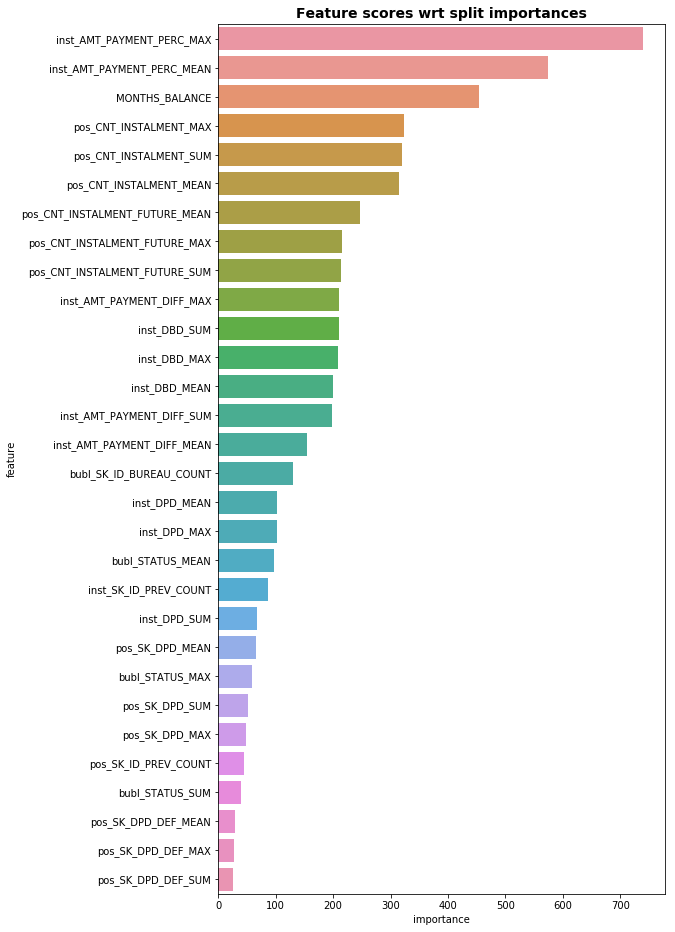

In [20]:
# Plot feature importances
feature_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)

best_features = feature_importance.iloc[:50].reset_index()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='importance', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)